In [ ]:
import catboost as cb
import contextily as ctx
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
import joblib
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from matplotlib.ticker import FuncFormatter


Primero voy a buscar mi dataset

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [206]:
barcelona = pd.read_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/result_barcelona_districs_zip_final.csv', sep = ";")
barcelona

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,hasSwimmingPool,hasTerrace,hasAirConditioning,hasBoxRoom,hasGarden,zip_code,size_category,cleaned_description,cinema,distancia_cinema
0,99117414,https://img4.idealista.com/blur/WEB_LISTING-M/...,BCNP2854,22,1,1600000.00,flat,sale,114.00,False,...,No data,True,True,No data,No data,8010,Very Large,impressive apartment sale 163m2 terrace locate...,Cinema 5D,5819924.17
1,101300670,https://img4.idealista.com/blur/WEB_LISTING-M/...,BCNP5151,29,1,1580000.00,flat,sale,202.00,True,...,No data,No data,No data,No data,No data,8008,Extra Large,sothebys international realty pleased present ...,Cinema 5D,5820797.14
2,104772587,https://img4.idealista.com/blur/WEB_LISTING-M/...,BCNP2636,45,4,980000.00,penthouse,sale,156.00,True,...,No data,True,No data,No data,No data,8007,Extra Large,four luxurious boutique apartment eixample spe...,Cinema 5D,5820229.13
3,100770574,https://img4.idealista.com/blur/WEB_LISTING-M/...,BCNP5175,23,1,870000.00,flat,sale,129.00,True,...,No data,No data,No data,No data,No data,8003,Very Large,exclusive property offer authentic characteris...,Cinema 5D,5818938.80
4,105932101,https://img4.idealista.com/blur/WEB_LISTING-M/...,BCN53025,35,3,495000.00,flat,sale,91.00,True,...,No data,True,No data,No data,No data,8003,Large,located emblematic born neighbourhood barcelon...,Cinema 5D,5819331.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,105882581,https://img4.idealista.com/blur/WEB_LISTING-M/...,No data,2,7,5000000.00,duplex,sale,500.00,True,...,True,True,True,True,True,8034,Extra Large,magnificent penthouse completely renovated sal...,Cinema 5D,5823345.86
8914,81411842,https://img4.idealista.com/blur/WEB_LISTING-M/...,CSM 163085V,29,No data,5600000.00,chalet,sale,1000.00,False,...,No data,True,False,True,True,8034,Extra Large,elegant mansion privileged location upper area...,Cinema 5D,5823887.90
8915,103461663,https://img4.idealista.com/blur/WEB_LISTING-M/...,Casa Claver,36,No data,5900000.00,chalet,sale,560.00,False,...,True,True,True,True,True,8017,Extra Large,one home present casa claver unique opportunit...,Cinema 5D,5824448.65
8916,98964029,https://img4.idealista.com/blur/WEB_LISTING-M/...,B07442BA,30,No data,7450000.00,chalet,sale,900.00,False,...,True,False,False,False,False,8017,Extra Large,spectacular modern house located upper area ba...,Cinema 5D,5824809.57


Cree una categoria que es "size_category" en funcion de los cuartiles de el tamaño de la vivienda y quiero ver si han estado bien distribuidos

Quiero trabajar sobre el dataset eliminando cosas para crear el modelo luego ya lo juntaremos con un merge, left join, inner join... o lo que convenga

In [207]:
barcelona_reduce = barcelona.copy()

In [208]:
barcelona_reduce.groupby('zip_code')['price'].describe().sort_values(by= 'mean', ascending= False)

,count,mean,std,min,25%,50%,75%,max
zip_code,,,,,,,,
8017,148.00,2205462.64,1911854.56,199000.00,910000.00,1908880.00,2812500.00,16750000.00
8034,428.00,1955215.42,2575769.29,159000.00,795000.00,1400000.00,2125000.00,21500000.00
8007,77.00,1844012.99,1610792.24,380000.00,1125000.00,1445000.00,2158000.00,13800000.00
8022,110.00,1577936.36,919748.57,249000.00,1061750.00,1495000.00,1890000.00,5400000.00
8021,151.00,1537112.58,1070478.05,400000.00,865000.00,1290000.00,1700000.00,6900000.00
...,...,...,...,...,...,...,...,...
8905,284.00,141087.86,68589.16,12000.00,90800.00,125000.00,164250.00,388000.00
8033,180.00,131050.53,73355.11,47400.00,90500.00,125000.00,150000.00,700000.00
8042,211.00,126501.83,44903.70,38500.00,90000.00,126000.00,161500.00,338000.00


In [209]:
barcelona_reduce['log_price'] = np.log(barcelona_reduce['price'])

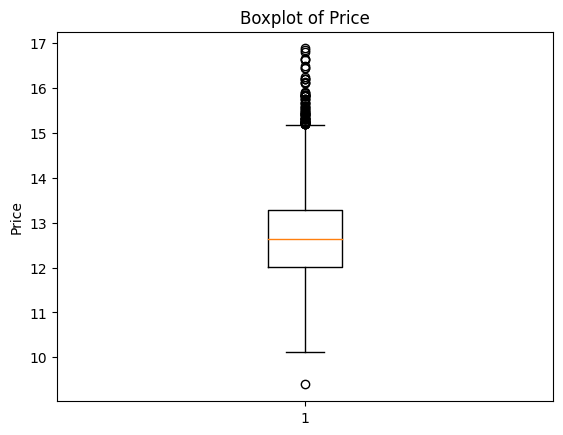

In [ ]:
# Creamos un boxplot del logaritmo del precio

plt.boxplot(barcelona_reduce['log_price'])

plt.title('Boxplot of Price')
plt.ylabel('Price')

formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


In [ ]:
# Se busca la media del log_price por codigo postal y se actualiza mediante map cada vivienda en ua columna nueva

prova = barcelona_reduce.groupby('zip_code')['log_price'].mean().reset_index()

mean_price_m2_log = prova.set_index('zip_code')['log_price']

barcelona_reduce['zip_mean_price'] = barcelona_reduce['zip_code'].map(mean_price_m2_log)



In [ ]:
# Se busca la media del m2 por codigo postal y se actualiza mediante map cada vivienda en ua columna nueva
barcelona_reduce['price_m2_mean_log'] = np.log(barcelona_reduce['price'] / barcelona_reduce['size'])

prova = barcelona_reduce.groupby('zip_code')['price_m2_mean_log'].mean().reset_index()

mean_price_m2_log = prova.set_index('zip_code')['price_m2_mean_log']

barcelona_reduce['price_m2_mean_log'] = barcelona_reduce['zip_code'].map(mean_price_m2_log)

In [213]:
barcelona_zip_price = barcelona_reduce[['zip_code','zip_mean_price', 'price_m2_mean_log']]
barcelona_zip_price

,zip_code,zip_mean_price,price_m2_mean_log
0,8010,14.06,8.98
1,8008,13.81,9.00
2,8007,14.24,9.17
3,8003,13.19,8.66
4,8003,13.19,8.66
...,...,...,...
8913,8034,14.09,8.85
8914,8034,14.09,8.85
8915,8017,14.31,8.64
8916,8017,14.31,8.64


In [214]:
barcelona_zip_price.to_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/zip_mean_log_price.csv', sep = ";", index = False)

In [215]:
barcelona_reduce[['zip_code', 'price_m2_mean_log','zip_mean_price' ]]

,zip_code,price_m2_mean_log,zip_mean_price
0,8010,8.98,14.06
1,8008,9.00,13.81
2,8007,9.17,14.24
3,8003,8.66,13.19
4,8003,8.66,13.19
...,...,...,...
8913,8034,8.85,14.09
8914,8034,8.85,14.09
8915,8017,8.64,14.31
8916,8017,8.64,14.31


In [216]:
# Comprovamos que no exista ningún NaN
barcelona_reduce.isna().sum()

propertyCode         0
thumbnail            0
externalReference    0
numPhotos            0
floor                0
                    ..
cinema               0
distancia_cinema     0
log_price            0
zip_mean_price       0
price_m2_mean_log    0
Length: 68, dtype: int64

In [217]:
barcelona_reduce.groupby('zip_code')['log_price'].mean()

zip_code
5030   11.83
8001   12.86
8002   13.44
8003   13.19
8004   12.49
        ... 
8950   13.53
8960   13.67
8970   12.61
8980   13.14
8991   12.24
Name: log_price, Length: 77, dtype: float64

In [ ]:
# Aignamos una categoria de precio a cada código postal

labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']

avg_log_price_by_zip = barcelona_reduce.groupby('zip_code')['log_price'].mean()
price_categories = pd.qcut(avg_log_price_by_zip, q=5, labels=labels)
barcelona_reduce['price_category_by_zip'] = barcelona_reduce['zip_code'].map(price_categories)

print(barcelona_reduce[['zip_code', 'log_price', 'price_category_by_zip']].head())


   zip_code  log_price price_category_by_zip
0      8010      14.29              Muy Alto
1      8008      14.27              Muy Alto
2      8007      13.80              Muy Alto
3      8003      13.68                  Alto
4      8003      13.11                  Alto


In [220]:
barcelona_reduce.describe()

,propertyCode,numPhotos,price,size,rooms,bathrooms,latitude,longitude,priceByArea,priceDropPercentage,phone1.phoneNumber,parkingSpacePrice,zip_code,distancia_cinema,log_price,zip_mean_price,price_m2_mean_log
count,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00,8918.00
mean,103850500.39,24.02,574457.67,118.25,2.94,1.71,2.15,41.40,4192.88,0.54,602529560.00,402.19,8337.74,5821763.71,12.72,12.72,8.19
std,5824999.45,16.21,949811.30,125.73,1.32,1.13,0.04,0.03,2405.19,1.73,450084006.80,3721.13,438.48,1934.76,0.96,0.75,0.43
min,320294.00,0.00,12000.00,16.00,0.00,0.00,2.05,41.35,47.00,0.00,0.00,0.00,5030.00,5817318.78,9.39,11.52,7.20
25%,103955183.75,13.00,166500.00,63.00,2.00,1.00,2.12,41.38,2460.00,0.00,0.00,0.00,8020.00,5820420.79,12.02,12.14,7.86
50%,105088150.00,23.00,310000.00,80.00,3.00,1.00,2.16,41.40,3750.00,0.00,932711503.00,0.00,8033.00,5821826.70,12.64,12.59,8.27
75%,105655310.50,33.00,589750.00,120.00,3.00,2.00,2.18,41.42,5333.00,0.00,936174751.00,0.00,8906.00,5823032.13,13.29,13.26,8.49
max,106053114.00,130.00,21500000.00,1800.00,25.00,21.00,2.27,41.48,29825.00,28.00,9165414952.00,100000.00,8991.00,5827720.17,16.88,14.31,9.17


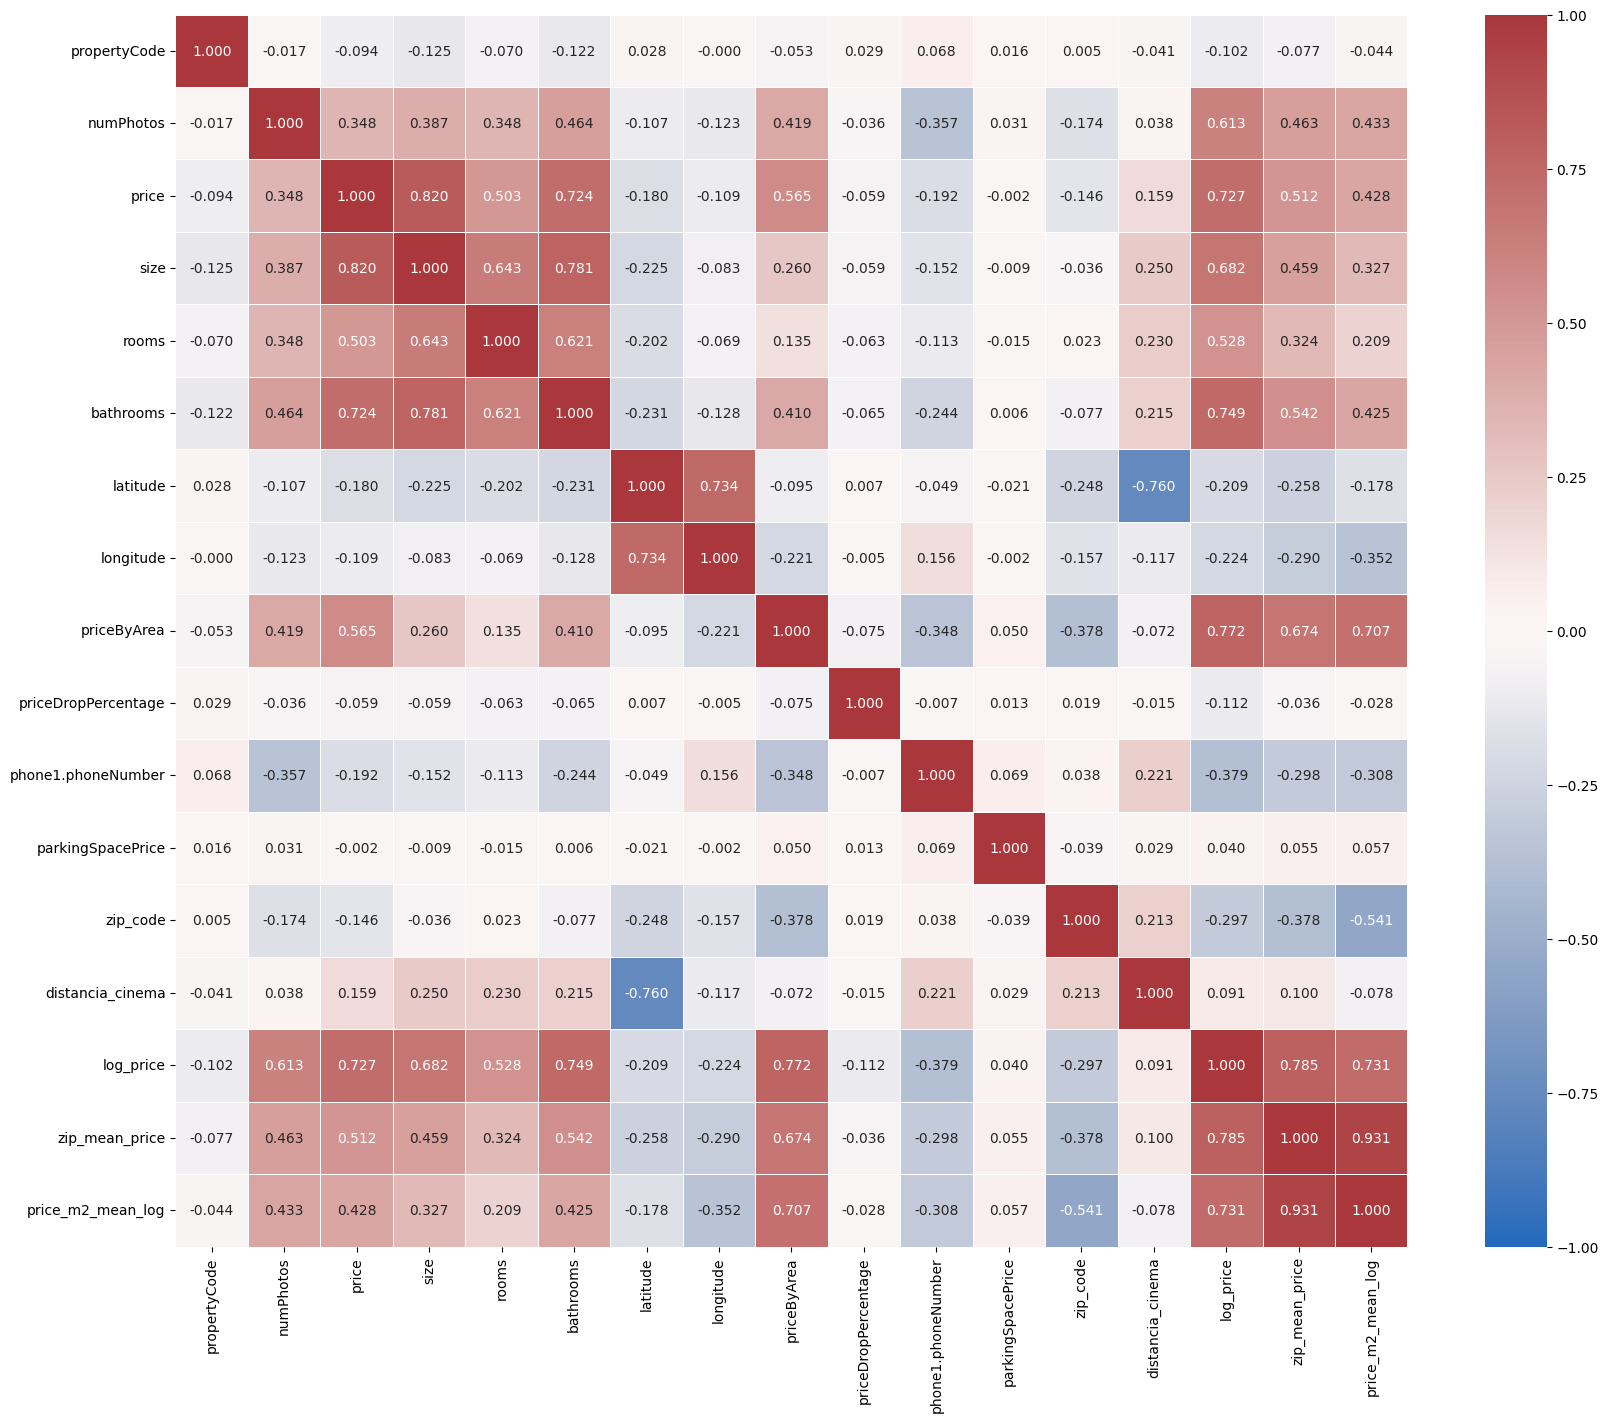

In [ ]:
# Matriz de correlación
corr_matrix = barcelona_reduce.select_dtypes(include=np.number).corr()
plt.figure(figsize=(20, 16))

sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    cmap="vlag",
    annot=True,
    fmt=".3f",
    annot_kws={"size": 10},
    square=True,
    linewidths=0.5,
)
plt.show()

In [222]:
barcelona_reduce['price_m2'] = barcelona_reduce['price'] / barcelona_reduce['size']

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   1.,   1.,   1.,   0.,   0.,   3.,   0.,   1.,   5.,
          3.,   9.,   6.,   6.,  14.,  22.,  14.,  19.,  26.,  22.,  17.,
         22.,  21.,  30.,  22.,  29.,  19.,  26.,  33.,  25.,  43.,  22.,
         39.,  35.,  43.,  37.,  21.,  53.,  29.,  68.,  45.,  60.,  43.,
         51.,  47.,  59.,  52.,  55.,  69.,  72.,  95.,  99.,  33., 114.,
         86.,  79.,  90.,  63., 128.,  93.,  62.,  79., 106., 101., 105.,
        111.,  45.,  91.,  27.,  90.,  38., 125.,  70.,  79., 128.,  35.,
        136.,  42., 152.,  65.,  50., 114., 126., 195.,  43.,  92.,  90.,
        108., 133.,  91., 112., 142.,  95., 104., 128.,  88.,  81., 122.,
         63.,  84.,  91., 124.,  69., 

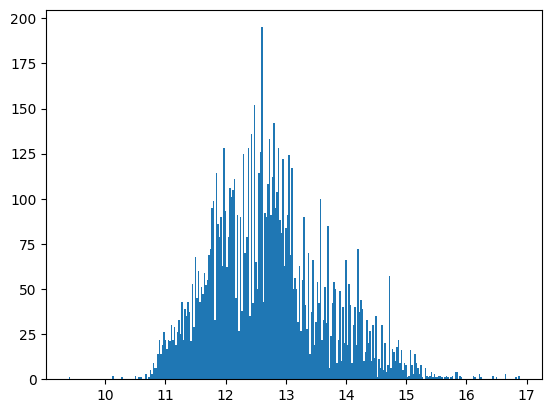

In [223]:
plt.hist(barcelona_reduce['log_price'], bins=300)

In [224]:
barcelona_reduce[['zip_mean_price','price_m2_mean_log', 'size', 'price', 'price_m2']]

,zip_mean_price,price_m2_mean_log,size,price,price_m2
0,14.06,8.98,114.00,1600000.00,14035.09
1,13.81,9.00,202.00,1580000.00,7821.78
2,14.24,9.17,156.00,980000.00,6282.05
3,13.19,8.66,129.00,870000.00,6744.19
4,13.19,8.66,91.00,495000.00,5439.56
...,...,...,...,...,...
8913,14.09,8.85,500.00,5000000.00,10000.00
8914,14.09,8.85,1000.00,5600000.00,5600.00
8915,14.31,8.64,560.00,5900000.00,10535.71
8916,14.31,8.64,900.00,7450000.00,8277.78


In [225]:
barcelona_reduce.columns

Index(['propertyCode', 'thumbnail', 'externalReference', 'numPhotos', 'floor',
       'price', 'propertyType', 'operation', 'size', 'exterior', 'rooms',
       'bathrooms', 'address', 'province', 'municipality', 'district',
       'country', 'neighborhood', 'locationId', 'latitude', 'longitude',
       'showAddress', 'url', 'description', 'hasVideo', 'status',
       'newDevelopment', 'favourite', 'newProperty', 'hasLift', 'priceByArea',
       'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'urgentVisualHighlight',
       'visualHighlight', 'preferenceHighlight', 'topHighlight',
       'topNewDevelopment', 'topPlus', 'priceDropValue', 'dropDate',
       'priceDropPercentage', 'commercialName', 'contactName', 'userType',
       'phone1.phoneNumber', 'typology', 'subTypology', 'subtitle', 'title',
       'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice',
       'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom',
       'hasGarden', 'zip_code', 'siz

In [226]:
barcelona_reduce.to_csv('/TFM Mercado Inmobiliario - Kschool/Metodología de Modelado/9. Código y datasets/Barcelona/Datasets/barcelona_clean_zip_reduce.csv', sep = ";", index = False)

In [ ]:
#Elimino columnas que creo que no son de interes
columns_delete = ['thumbnail','neighborhood', 'externalReference', 'numPhotos','operation','address', 'province', 'municipality', 'district',
       'country', 'locationId', 'latitude', 'longitude',
       'showAddress', 'url', 'description', 'hasVideo', 'status',
       'newDevelopment', 'favourite', 'newProperty', 'hasPlan', 'has3DTour', 'has360','urgentVisualHighlight',
       'visualHighlight', 'preferenceHighlight', 'topHighlight',
       'topNewDevelopment', 'topPlus','dropDate',
       'priceDropPercentage', 'commercialName', 'contactName', 'userType',
       'phone1.phoneNumber', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice']

barcelona_reduce.drop(columns_delete,axis = 1,  inplace = True)

In [162]:
barcelona_reduce = barcelona_reduce[['zip_mean_price','price_m2_mean_log','log_price', 'floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
    'hasLift',   'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace',
    'hasAirConditioning', 'hasBoxRoom', 'hasGarden', 'zip_code']]

In [ ]:
# Provamos diferentes modelos para obtener el que mejor se nos ajuste

features = [
    'zip_mean_price','price_m2_mean_log','floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
    'hasLift', 'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace',
    'hasAirConditioning', 'hasBoxRoom', 'hasGarden'
]
X = barcelona_reduce[features]
y = barcelona_reduce['log_price']

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('SVR', SVR()),
    ('XGBoost', xgb.XGBRegressor()),
    ('CatBoost', cb.CatBoostRegressor(silent=True)),
    ('LGBM', lgb.LGBMRegressor()),
    ('Lasso Regression', Lasso()),
    ('Ridge Regression', Ridge()),
    ('ElasticNet', ElasticNet()),
    ('Neural Networks', MLPRegressor(max_iter=1000)),
    ('KNN', KNeighborsRegressor())
]

results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    results.append([name, r2, rmse])

results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE'])
results_df



Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 7134, number of used features: 36
[LightGBM] [Info] Start training from score 12.716898


Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Python_kernels/kschool_3_12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,R2,RMSE
0,Linear Regression,0.87,0.35
1,Random Forest,0.92,0.27
2,Decision Tree,0.86,0.36
3,SVR,0.80,0.43
4,XGBoost,0.92,0.27
5,CatBoost,0.93,0.26
6,LGBM,0.92,0.27
7,Lasso Regression,0.43,0.73
8,Ridge Regression,0.87,0.35
9,ElasticNet,0.43,0.73


### Esta parte esta comentado devido al tiempo de computo, 

In [ ]:
## Realizamos el ajuste de hiperparametros mediante un gridsearch, del modelo XGboost seleccionado anteriormente

# features = [
#     'floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
#     'hasLift', 'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace',
#     'hasAirConditioning', 'hasBoxRoom', 'hasGarden', 'zip_code', 'priceDropValue'
# ]
# X = barcelona_reduce[features]
# y = barcelona_reduce['log_price']

# X = pd.get_dummies(X, drop_first=True)
# X = X.fillna(0)
# y = y.fillna(y.mean())

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# xgboost_model = xgb.XGBRegressor(random_state=42)

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5,  6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
#                            scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_rmse = -grid_search.best_score_

# print(f"Best parameters found: {best_params}")
# print(f"Best RMSE: {best_rmse:.4f}")

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# test_rmse = mean_squared_error(y_test, y_pred) ** 0.5
# print(f"Test RMSE: {test_rmse:.4f}")


Los mejores hiperparametros:

Best parameters found: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best RMSE: 0.2633

In [ ]:
# Entrenamos el modelo con los mejores hiperparametros obtenidos

features = [
    'zip_mean_price','price_m2_mean_log','floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
    'hasLift',   'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace',
    'hasAirConditioning', 'hasBoxRoom', 'hasGarden', 'zip_code',
]
X = barcelona_reduce[features]
y = barcelona_reduce['log_price']

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 300,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 1.0
}

xgboost_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("XGBoost with optimized hyperparameters:")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²: {r2:.4f}")


XGBoost with optimized hyperparameters:
  RMSE: 0.2601
  R²: 0.9286


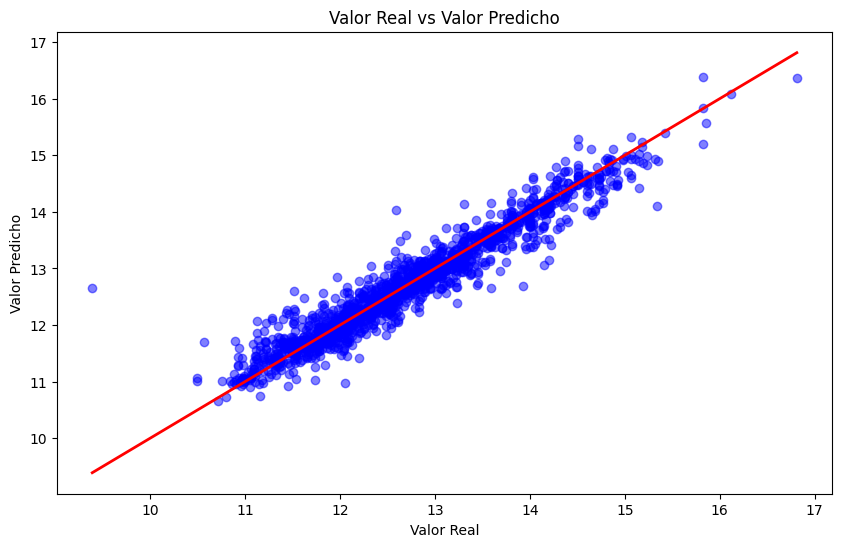

In [ ]:
# Visualización del valor real vs el valor predicho
y_pred = xgboost_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Valor Real vs Valor Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.show()

In [169]:
barcelona_reduce.columns

Index(['zip_mean_price', 'price_m2_mean_log', 'log_price', 'floor',
       'propertyType', 'size', 'exterior', 'rooms', 'bathrooms', 'hasLift',
       'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace',
       'hasAirConditioning', 'hasBoxRoom', 'hasGarden', 'zip_code'],
      dtype='object')

Python_kernels/kschool_3_12/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
Python_kernels/kschool_3_12/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
Python_kernels/kschool_3_12/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
Python_kernels/kschool_3_12/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
Python_kernels/kschool_3_12/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
Python_kernels/kschool_3_12/lib/python3.

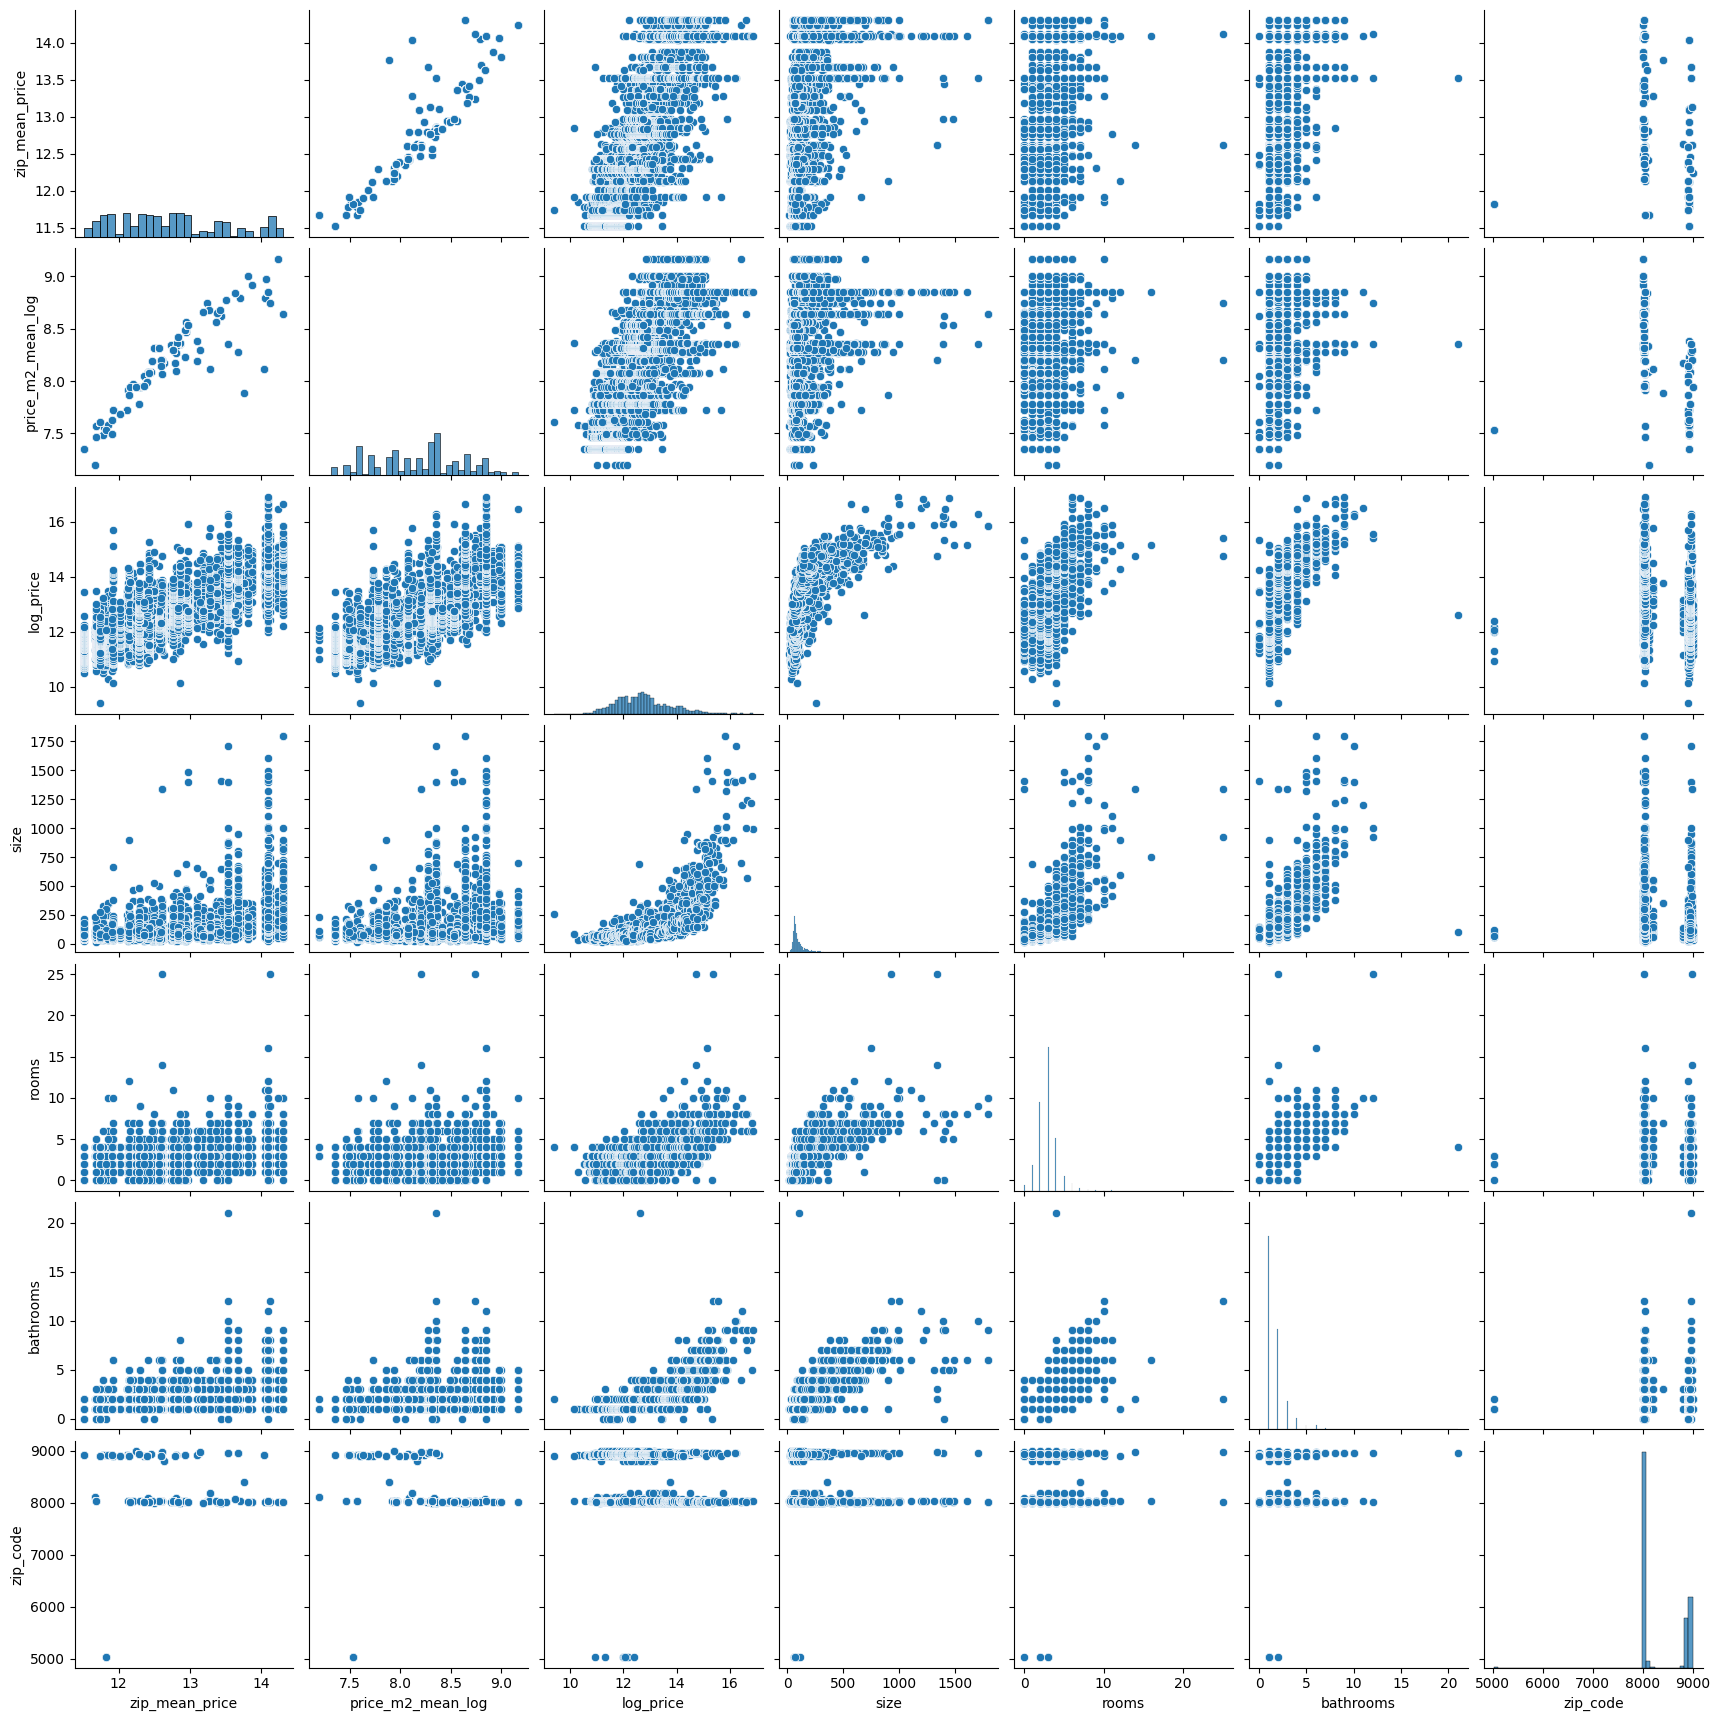

In [ ]:
# Visualizamos todos los datos mediante un paiplot

numeric_features = barcelona_reduce.select_dtypes(include=['number'])

sns.pairplot(numeric_features, kind="scatter", palette="Set2")
plt.show()


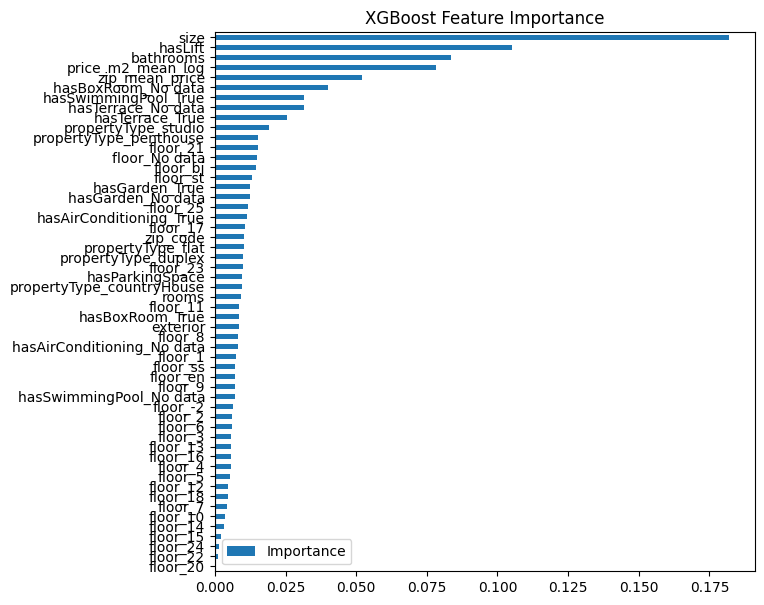

In [ ]:
# Visualización de las variables más importantes del modelo Xgboost

importances = xgboost_model.feature_importances_

importance_df = pd.DataFrame(
    importances, columns=["Importance"], index=X_train.columns
)

importance_df.sort_values(by="Importance", ascending=True).plot(kind="barh", figsize=(9, 7))
plt.title("XGBoost Feature Importance")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

In [172]:
importance_df.sort_values(by= 'Importance', ascending= False)

,Importance
size,0.18
hasLift,0.11
bathrooms,0.08
price_m2_mean_log,0.08
zip_mean_price,0.05
hasBoxRoom_No data,0.04
hasSwimmingPool_True,0.03
hasTerrace_No data,0.03
hasTerrace_True,0.03
propertyType_studio,0.02


In [173]:
importance_df.to_csv('Downloads/importance.csv')

In [ ]:
# Guarda el modelo entrenado

joblib.dump(xgboost_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [ ]:
comparison_df = pd.DataFrame({
    'Valor Real': y_test,
    'Valor Predicho': y_pred
})

comparison_df

      Valor Real  Valor Predicho
4478       14.51           14.59
8144       12.37           12.38
3130       14.48           14.48
1992       12.90           13.01
2458       13.08           13.15
...          ...             ...
1155       14.46           14.09
2128       12.61           12.38
7024       12.64           12.79
1108       13.65           13.71
6596       11.41           11.66

[1784 rows x 2 columns]


### Este codigo esta comentado ya que pruebas de validación manual

In [176]:
# Esta parte del codigo se ha provado solamente para comprovar manualmente la predicción del precio
# xgb_model_prova_1 = joblib.load('xgboost_model.pkl')

# X_train_class = pd.DataFrame(columns=[
#     'floor_-2', 'floor_1', 'floor_10', 'floor_11', 'floor_12', 'floor_13', 'floor_14', 'floor_15', 'floor_16', 'floor_17', 'floor_18', 'floor_2', 'floor_20', 'floor_21', 'floor_22', 'floor_23', 'floor_24', 'floor_25', 'floor_3', 'floor_4', 'floor_5', 'floor_6', 'floor_7', 'floor_8', 'floor_9', 'floor_bj', 'floor_en', 'floor_ss', 'floor_st',
#     'propertyType_countryHouse', 'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse', 'propertyType_studio',
#     'size', 'exterior', 'rooms', 'bathrooms', 'hasLift', 'hasStaging', 'hasParkingSpace', 'hasSwimmingPool', 'hasTerrace', 'hasAirConditioning', 'hasBoxRoom', 'hasGarden', 'zip_code'
# ])

# def predict_price():

#     # floor = widgets.Dropdown(
#     #     options=['-2', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '3', '4', '5', '6', '7', '8', '9', 'No data', 'bj', 'en', 'ss', 'st'],
#     #     description='Floor:'
#     # )
#     propertyType = widgets.Dropdown(
#         options=['countryHouse', 'duplex', 'flat', 'penthouse', 'studio'],
#         description='Property Type:'
#     )
#     size = widgets.FloatText(description='Size:')
#     exterior = widgets.Dropdown(
#         options=[True, False],
#         description='Exterior:'
#     )
#     rooms = widgets.IntText(description='Rooms:')
#     bathrooms = widgets.IntText(description='Bathrooms:')
#     # hasLift = widgets.Dropdown(
#     #     options=[True, False],
#     #     description='Has Lift:'
#     # )
#     # hasStaging = widgets.Dropdown(
#     #     options=[True, False],
#     #     description='Has Staging:'
#     # )
#     hasParkingSpace = widgets.Dropdown(
#         options=[True, False],
#         description='Has Parking Space:'
#     )
#     hasSwimmingPool = widgets.Dropdown(
#         options=['No data', True, False],
#         description='Has Swimming Pool:'
#     )
#     hasTerrace = widgets.Dropdown(
#         options=['No data', True, False],
#         description='Has Terrace:'
#     )
#     hasAirConditioning = widgets.Dropdown(
#         options=['No data', True, False],
#         description='Has Air Conditioning:'
#     )
#     hasBoxRoom = widgets.Dropdown(
#         options=['No data', True, False],
#         description='Has Box Room:'
#     )
#     hasGarden = widgets.Dropdown(
#         options=['No data', True, False],
#         description='Has Garden:'
#     )
#     zip_code = widgets.IntText(description='Zip Code:')

#     # display(floor, propertyType, size, exterior, rooms, bathrooms, hasLift, hasStaging, hasParkingSpace, hasSwimmingPool, hasTerrace, hasAirConditioning, hasBoxRoom, hasGarden, zip_code)
#     display( propertyType, size, exterior, rooms, bathrooms,   hasParkingSpace, hasSwimmingPool, hasTerrace, hasAirConditioning, hasBoxRoom, hasGarden, zip_code)

#     def on_button_clicked(b):

#         input_data = pd.DataFrame({
#             # 'floor': [floor.value],
#             'propertyType': [propertyType.value],
#             'size': [size.value],
#             'exterior': [exterior.value],
#             'rooms': [rooms.value],
#             'bathrooms': [bathrooms.value],
#             # 'hasLift': [hasLift.value],
#             # 'hasStaging': [hasStaging.value],
#             'hasParkingSpace': [hasParkingSpace.value],
#             'hasSwimmingPool': [hasSwimmingPool.value],
#             'hasTerrace': [hasTerrace.value],
#             'hasAirConditioning': [hasAirConditioning.value],
#             'hasBoxRoom': [hasBoxRoom.value],
#             'hasGarden': [hasGarden.value],
#             'zip_code': [zip_code.value],
#         })

#         input_data = pd.get_dummies(input_data, drop_first=True)

#         model_columns = xgb_model_prova_1.get_booster().feature_names
#         input_data = input_data.reindex(columns=model_columns, fill_value=0)

#         predicted_price = xgb_model_prova_1.predict(input_data)

#         predicted_price = np.exp(predicted_price)

#         print(f"El precio predicho es: {predicted_price[0]:,.2f} €")

#     button = widgets.Button(description="Predecir Precio")
#     button.on_click(on_button_clicked)
#     display(button)

# predict_price()